<a href="https://colab.research.google.com/github/MWFK/Fraud-Detection/blob/main/Fraud_Detection_Algos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credits

In [ ]:
# Author: Mouafek Ayadi (but not the original code creator!)
# Contact: mouafek.ayadi@esprit.tn 
#          https://www.linkedin.com/in/mouafek-ayadi/
# Date: 2019/2020

# The source Code have been developed based on deeplearning.ai courses materials, tensorflow.org documentation and other open source resources. 
# that have been carefully documented in a separate document that you should find it alongside this notebook.
# The original code is under the Apache License, Version 2.0 (the "License");

# Notes

We Have omitted the Data preparation process

We have omitted the function that returns the detected fraudulent transactions

Link to the Data Sample

https://github.com/MWFK/Fraud-Detection/blob/main/creditcard%20sample.xlsx


# Ongoing
1- Add the fitting time to the benchmark list

2- Add Tensorboard

# Librairies

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.6.0


# Trailing window

In [ ]:
##################################################################################### Explanation of TF windowed dataset
# We're creating TF Windowed dataset, which have more methods than a regular dataset
# Represents a potentially large set of elements => tf.data.Dataset(variant_tensor)

def windowed_dataset(series, window_size, batch_size, shuffle_buffer): # [0] This returns a tf.data.Dataset object when a series is passed in along with the other arguments like window_size, batch_size, shuffle_buffer_size
                                                                       #     In this object each element is a batch of 32 windows and each window contains 30 values.
    
    series = tf.expand_dims(series, axis=-1)                           # [1] explanation above  
    ds = tf.data.Dataset.from_tensor_slices(series)                    # [2] explanation above
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)      #     Maps map_func across this dataset and flattens the result.
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))               # [3] explanation above
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))                             # [4] explanation above => splitting data into input and target

    return ds.batch(batch_size).prefetch(1)                            # [5] explanation above

# Forecast function

In [ ]:
# We take the DNN model, and we try to apply it to our windowed series
# So after training it will help us forecast batches of our windowed series 
# we'll have 32 windowd with size of 30 in each batch, where each windowd will have one new value each time.
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    # No map or shuffle, this was done in the windowed_dataset()
    forecast = model.predict(ds)
    return forecast

# RNN Model

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

# Simple RNN
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]), # since our dataset is windowed, then we'll construct one tensor, through pending each windowd to the end of the tensor
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400.0)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history_rnn = model.fit(train_set, epochs=150) 

# RNN MAE and Loss

<Figure size 432x288 with 0 Axes>

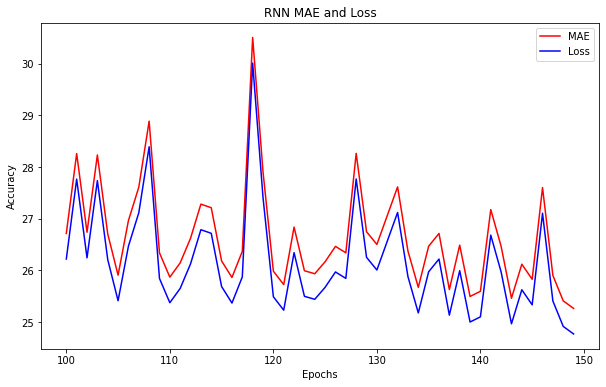

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history_rnn.history['mae']
loss=history_rnn.history['loss']

epochs=range(len(loss)) # Get number of epochs


epochs_zoom = epochs[100:150]
mae_zoom = mae[100:150]
loss_zoom = loss[100:150]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------

plt.figure(figsize=(10, 6))

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('RNN MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [ ]:
# Add Model Details to the benchmark list
columns = ['Model', 'Layers', 'Units_per_Layer','Optimizer', 'MAE Metric', 'Huber Loss']
Benchmark  = Benchmark.append(pd.Series(['RNN', '2*SimpleRNN', '40', 'SGD(lr=1e-5, momentum=0.9)', mae[-1], loss[-1]], index = columns), ignore_index=True)
Benchmark

,Model,Layers,Units_per_Layer,Optimizer,MAE Metric,Huber Loss
0,RNN,2*SimpleRNN,40,"SGD(lr=1e-5, momentum=0.9)",25.264061,24.769438


# LSTM Model

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([

  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  #tf.keras.layers.Lambda(lambda x: x * 400)
])

# We have inferred from the previouss cell that the preferred Learning rate is 1e-5
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history_lstm = model.fit(train_set,epochs=150) 

# LSTM MAE and Loss

<Figure size 432x288 with 0 Axes>

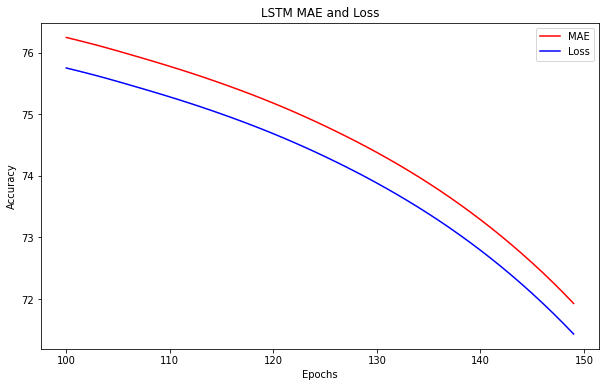

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history_lstm.history['mae']
loss=history_lstm.history['loss']

epochs=range(len(loss)) # Get number of epochs

epochs_zoom = epochs[100:150]
mae_zoom = mae[100:150]
loss_zoom = loss[100:150]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------

plt.figure(figsize=(10, 6))

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('LSTM MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [ ]:
# Add Model Details to the benchmark list
Benchmark  = Benchmark.append(pd.Series(['LSTM', '2*LSTM, 2*Dense', '2*40, 30 10', 'SGD(lr=1e-5, momentum=0.9)', mae[-1], loss[-1]], index = columns), ignore_index=True)
Benchmark

,Model,Layers,Units_per_Layer,Optimizer,MAE Metric,Huber Loss
0,RNN,2*SimpleRNN,40,"SGD(lr=1e-5, momentum=0.9)",25.264061,24.769438
1,LSTM,"2*LSTM, 2*Dense","2*40, 30 10","SGD(lr=1e-5, momentum=0.9)",71.929543,71.433273


# BLSTM Model

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session
# A common use-case for clear_session is releasing memory when building models and layers in a loop.
# Clears any internal variables, which means models will not impact later versions of themselves
tf.keras.backend.clear_session()

# This sets the graph-level seed.
# https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/random/set_seed
tf.random.set_seed(51)

# I's for operation level
np.random.seed(51)

# https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session
# A common use-case for clear_session is releasing memory when building models and layers in a loop.
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Windowed BI-LSTM
model = tf.keras.models.Sequential([
  #tf.keras.layers.Lambda(lambda x: tf.expand_dims(x),# Given a tensor input, this operation inserts a dimension of size 1 at the dimension index axis of input's shape. # https://www.tensorflow.org/api_docs/python/tf/expand_dims
                                                     #input_shape=[None])),     # This means that the model can take sequences of any length
                                    
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
  
  # The windowed_dataset() return two dimensional batches, with the first being the batch size and the second being the number of timesteps 
  # But the RNN expects three dimensions, so the lambda layer, help fix the difference in dimensions, by adding expannding the array by one dimension

  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),

  # input a sequence and don't output it, except for the last one (sequence to vector RNN), which is the default behavior of Keras TF, 
  # otherwise we set the return_sequence=False and we we'll have (sequence to sequence)

  # The output of the layer is three dimensionals [batch_size * number_units(nulber of units in a cell) * overall_steps(number of cells)]

  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0) #400.0

  # For example the activation function of the RNN use tanH function which have values between -1 and 1, 
  # so we multipky the output by 100, so we can have the regular values of our input time series.
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), # Less sensitive to outliers
              optimizer=optimizer,
              metrics=["mae"])
history_blstm = model.fit(dataset, epochs=150)

# BLSTM MAE & Loss

<Figure size 432x288 with 0 Axes>

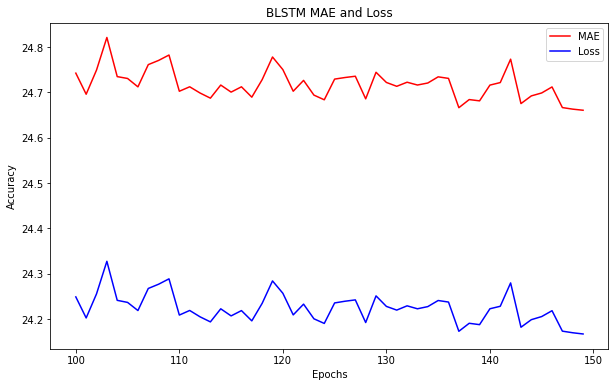

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history_blstm.history['mae']
loss=history_blstm.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------


epochs_zoom = epochs[100:150]
mae_zoom = mae[100:150]
loss_zoom = loss[100:150]


plt.figure(figsize=(10, 6))

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('BLSTM MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [ ]:
# Add Model Details to the benchmark list
Benchmark  = Benchmark.append(pd.Series(['BLSTM', '2*BLSTM', '32', 'SGD(lr=1e-5, momentum=0.9)', mae[-1], loss[-1]], index = columns), ignore_index=True)
Benchmark

,Model,Layers,Units_per_Layer,Optimizer,MAE Metric,Huber Loss
0,RNN,2*SimpleRNN,40,"SGD(lr=1e-5, momentum=0.9)",25.264061,24.769438
1,LSTM,"2*LSTM, 2*Dense","2*40, 30 10","SGD(lr=1e-5, momentum=0.9)",71.929543,71.433273
2,BLSTM,2*BLSTM,32,"SGD(lr=1e-5, momentum=0.9)",24.660589,24.167021


# CNN LSTM Model

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size) # We take a window of x_train
print("train_set= ",train_set)
print("\n x_train.shape= ",x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]), # We have specified the input shape here so we need to change the windowed_dataset() => it works but foes not give the same result
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history_cnn_lstm = model.fit(train_set, epochs=150)


# CNN LSTM MAE & Loss

<Figure size 432x288 with 0 Axes>

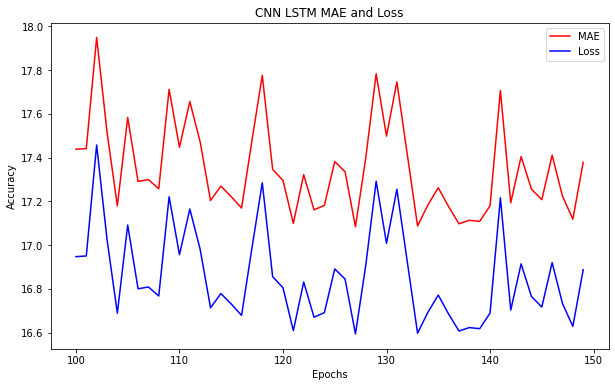

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history_cnn_lstm.history['mae']
loss=history_cnn_lstm.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------


epochs_zoom = epochs[100:150]
mae_zoom = mae[100:150]
loss_zoom = loss[100:150]


plt.figure(figsize=(10, 6))

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('CNN LSTM MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [ ]:
# Add Model Details to the benchmark list
Benchmark  = Benchmark.append(pd.Series(['CNN LSTM', 'Conv1D, 2*LSTM, 2*Dense', '32, 2*64, 30 10', 'SGD(lr=1e-5, momentum=0.9)', mae[-1], loss[-1]], index = columns), ignore_index=True)
Benchmark

,Model,Layers,Units_per_Layer,Optimizer,MAE Metric,Huber Loss
0,RNN,2*SimpleRNN,40,"SGD(lr=1e-5, momentum=0.9)",25.264061,24.769438
1,LSTM,"2*LSTM, 2*Dense","2*40, 30 10","SGD(lr=1e-5, momentum=0.9)",71.929543,71.433273
2,BLSTM,2*BLSTM,32,"SGD(lr=1e-5, momentum=0.9)",24.660589,24.167021
3,CNN LSTM,"Conv1D, 2*LSTM, 2*Dense","32, 2*64, 30 10","SGD(lr=1e-5, momentum=0.9)",17.378454,16.887781


# CNN BLSTM Model

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Windowed CNN BLSTM
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),    
  
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),

  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),

  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400.0)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=optimizer,
              metrics=["mae"])
history_cnn_blstm = model.fit(dataset, epochs=150)

# CNN BLSTM MAE and Loss

<Figure size 432x288 with 0 Axes>

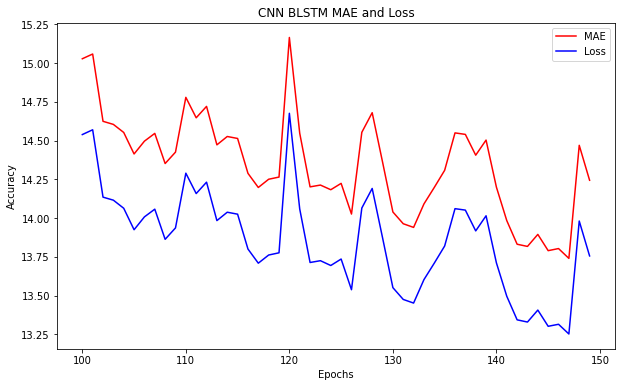

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history_cnn_blstm.history['mae']
loss=history_cnn_blstm.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------


epochs_zoom = epochs[100:150]
mae_zoom = mae[100:150]
loss_zoom = loss[100:150]


plt.figure(figsize=(10, 6))

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('CNN BLSTM MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [ ]:
# Add Model Details to the benchmark list
Benchmark  = Benchmark.append(pd.Series(['CNN BLSTM', 'Conv1D, 2*BLSTM, 2*LSTM, 2*Dense', '32, 2*32, 2*64, 30 10', 'SGD(lr=1e-5, momentum=0.9)', mae[-1], loss[-1]], index = columns), ignore_index=True)

# CNN GRU Model

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size) # We take a window of x_train
print("train_set= ",train_set)
print("\n x_train.shape= ",x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]), # We have specified the input shape here so we need to change the windowed_dataset() => it works but foes not give the same result
  tf.keras.layers.GRU(64, return_sequences=True),
  tf.keras.layers.GRU(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history_cnn_gru = model.fit(train_set, epochs=150)


# CNN GRU MAE & Loss

<Figure size 432x288 with 0 Axes>

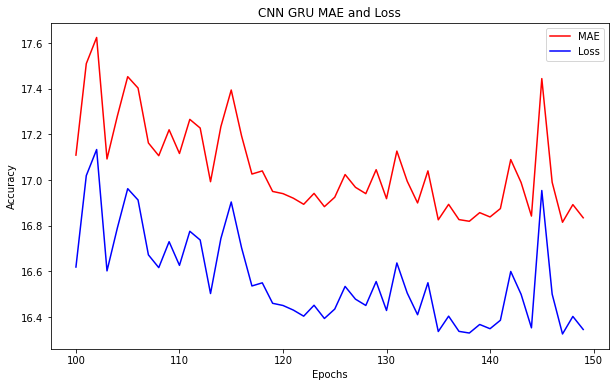

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae  = history_cnn_gru.history['mae']
loss = history_cnn_gru.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------


epochs_zoom = epochs[100:150]
mae_zoom = mae[100:150]
loss_zoom = loss[100:150]


plt.figure(figsize=(10, 6))

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('CNN GRU MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [ ]:
# Add Model Details to the benchmark list
Benchmark  = Benchmark.append(pd.Series(['CNN GRU', 'Conv1D, 2*GRU, 2*Dense', '32, 2*64, 30 10', 'SGD(lr=1e-5, momentum=0.9)', mae[-1], loss[-1]], index = columns), ignore_index=True)
Benchmark

,Model,Layers,Units_per_Layer,Optimizer,MAE Metric,Huber Loss
0,CNN GRU,"Conv1D, 2*GRU, 2*Dense","32, 2*64, 30 10","SGD(lr=1e-5, momentum=0.9)",16.834759,16.345789


# CNN BIGRU Model

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Windowed CNN BLSTM
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),    
  
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),

  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True)),

  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400.0)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=optimizer,
              metrics=["mae"])
history_cnn_bigru = model.fit(dataset, epochs=150)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          12672     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 64)          18816     
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          33024     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1

# CNN BIGRU MAE & Loss

<Figure size 432x288 with 0 Axes>

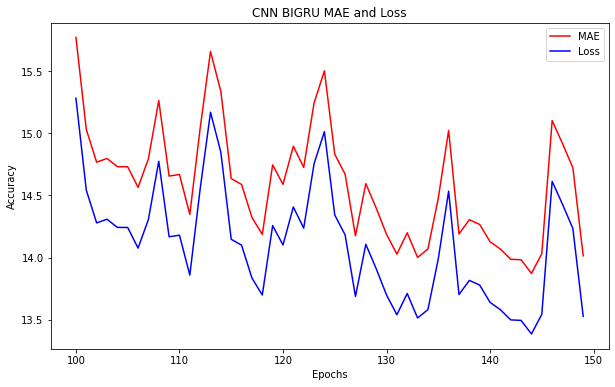

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history_cnn_bigru.history['mae']
loss=history_cnn_bigru.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------


epochs_zoom = epochs[100:150]
mae_zoom = mae[100:150]
loss_zoom = loss[100:150]


plt.figure(figsize=(10, 6))

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('CNN BIGRU MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [ ]:
# Add Model Details to the benchmark list
Benchmark  = Benchmark.append(pd.Series(['CNN BIGRU', 'Conv1D, 2*BIGRU, 2*BIGRU, 2*Dense', '32, 2*32, 2*64, 30 10', 'SGD(lr=1e-5, momentum=0.9)', mae[-1], loss[-1]], index = columns), ignore_index=True)
Benchmark

,Model,Layers,Units_per_Layer,Optimizer,MAE Metric,Huber Loss
0,CNN GRU,"Conv1D, 2*GRU, 2*Dense","32, 2*64, 30 10","SGD(lr=1e-5, momentum=0.9)",16.834759,16.345789
1,CNN BIGRU,"Conv1D, 2*BIGRU, 2*BIGRU, 2*Dense","32, 2*32, 2*64, 30 10","SGD(lr=1e-5, momentum=0.9)",14.013884,13.525953


# Benchmark

In [ ]:
Benchmark

,Model,Layers,Units_per_Layer,Optimizer,MAE Metric,Huber Loss
0,CNN GRU,"Conv1D, 2*GRU, 2*Dense","32, 2*64, 30 10","SGD(lr=1e-5, momentum=0.9)",16.834759,16.345789
1,CNN BIGRU,"Conv1D, 2*BIGRU, 2*BIGRU, 2*Dense","32, 2*32, 2*64, 30 10","SGD(lr=1e-5, momentum=0.9)",14.013884,13.525953


In [ ]:
print('Best Model MAE  wise:\n', Benchmark[Benchmark['MAE Metric'] == Benchmark['MAE Metric'].min()])   
print('Best Model Loss wise:\n', Benchmark[Benchmark['Huber Loss'] == Benchmark['Huber Loss'].min()])  

Best Model MAE  wise:
        Model                             Layers  ... MAE Metric Huber Loss
1  CNN BIGRU  Conv1D, 2*BIGRU, 2*BIGRU, 2*Dense  ...  14.013884  13.525953

[1 rows x 6 columns]
Best Model Loss wise:
        Model                             Layers  ... MAE Metric Huber Loss
1  CNN BIGRU  Conv1D, 2*BIGRU, 2*BIGRU, 2*Dense  ...  14.013884  13.525953

[1 rows x 6 columns]
